In [1]:
import sys
import numpy as np
from matplotlib import colors as mcolors

sys.path.append('../../..')

from seismicpro.src import SeismicDataset, FieldIndex, TraceIndex
from seismicpro.batchflow import Pipeline, B, V, C, W
from seismicpro.batchflow.models.torch import UNet
from seismicpro.batchflow.utils import plot_results_by_config, show_research, print_results
from seismicpro.batchflow.research import Research, Results, Option, KV, RP, REU, RI

from datasets.paths import *

In [11]:
# Global constants
B_SIZE = 512
NUM_ITERS = 3000                                # number of iterations to train each model for
N_REPS = 1                                      # number of times to repeat each model train
RESEARCH_NAME = 'research3x3'                   # name of Research object
DEVICES = [0, 1, 2, 3, 4, 5, 6, 7]              # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 200

Avaliable datasets.

In [12]:
index1 = FieldIndex(name='raw', path=pal_raw, markup_path=pal_markup)
index2 = FieldIndex(name='raw', path=wz_raw, markup_path=wz_markup)
index3 = FieldIndex(name='raw', path=vor_raw, markup_path=vor_markup)

Split indices.   
Datasets for validation are stored in the list `test_data`

In [13]:
test_data = []
for index in [index1, index2, index3]:
    index.split(shuffle=42)
    test_data.append(SeismicDataset(TraceIndex(index.test)))

In [16]:
config = {
    'inputs': {'masks': dict(classes=2)},
    'body/encoder/blocks/filters': [16, 32, 64, 128, 256],
    'body/decoder/blocks/filters': [16, 32, 64, 128, 256][::-1],
    'body/embedding/filters': 512,
    'optimizer': C('optimizer'),
    'optimizer': ('Adam', {'lr': 0.001}),
    'device': C('device'),
}

In [23]:
train_pipeline = (Pipeline()
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', [])
                      .load(components='raw', fmt='segy', tslice=slice(0, 1000))
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss',mode='w'))
                      .run_later(B_SIZE, n_epochs=None, drop_last=True, shuffle=42)
                 ) << C('train_data')

In [24]:
def test_pipeline(validation_data, import_from):
    test_pipeline = (validation_data.p
                      .import_model('my_model', import_from)
                      .init_variable('true', [])
                      .init_variable('predictions', [])
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .update(V('true', mode='a'), B('mask'))
                      .add_components(components='predictions')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .predict_model('my_model', B('raw'),
                                     fetches='predictions',  save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .update(V('predictions', mode='a'), B('predictions'))
                      .run_later(1000, n_epochs=1, drop_last=False, shuffle=False))
    return test_pipeline 

In [25]:
def mae(iteration, import_from, validation_data):
    res = []
    for data in validation_data:
        pipeline = test_pipeline(data, import_from)
        pipeline.run()
        pred = np.hstack(np.concatenate(pipeline.v('predictions')))
        true = np.argmax(np.stack(np.concatenate(pipeline.v('true'))), axis=1)
        res.append(np.mean(np.abs(true - pred)))
    return tuple(res)

Define the grid of parameters for search as well as research object.

In [26]:
domain = Option('train_data', [KV(SeismicDataset(TraceIndex(index1.train)), 'PAL'), 
                               KV(SeismicDataset(TraceIndex(index2.train)), 'WZ'), 
                               KV(SeismicDataset(TraceIndex(index3.train)), 'VOR'), 
                               KV(SeismicDataset(TraceIndex(index1.train + index2.train)), 'PAL + WZ'), 
                               KV(SeismicDataset(TraceIndex(index1.train + index3.train)), 'PAL + VOR'), 
                               KV(SeismicDataset(TraceIndex(index2.train + index3.train)), 'WZ + VOR'), 
                               KV(SeismicDataset(TraceIndex(index1.train + index2.train + index3.train)), 'PAL + WZ + VOR')])

In [27]:
research = (Research()
    .init_domain(domain, n_reps=N_REPS)
    .add_pipeline(train_pipeline, variables='loss', name='train_ppl', logging=True)
    .add_callable(mae, returns=['PAL', 'WZ', 'VOR'], name='test_mae', execute=TEST_FREQUENCY,  
                  iteration=RI(), import_from=RP('train_ppl'), validation_data=test_data)
)

Now it's time to train research instance.

In [28]:
!rm -r $RESEARCH_NAME

research.run(NUM_ITERS, workers=WORKERS, name=RESEARCH_NAME, devices=DEVICES, bar=True)

Research research3x3 is starting...


Domain updated: 0: 100%|██████████| 21000/21000.0 [16:12<00:00, 21.59it/s]


### Results

Loss functions vs a number of iterations for each parameters set:

In [29]:
results = Results(path=RESEARCH_NAME, concat_config=True)

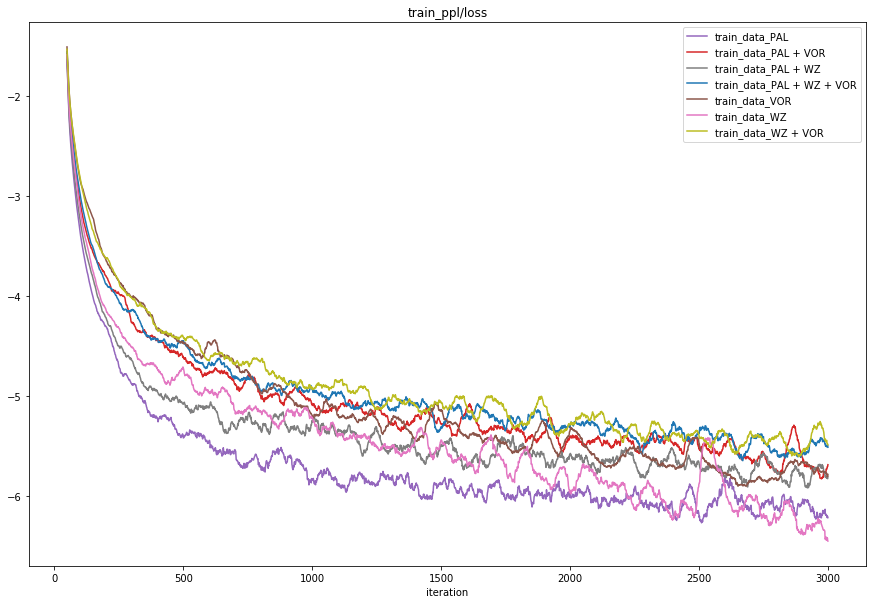

In [30]:
show_research(results.df, layout=['train_ppl/loss'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=True, rolling_window=50, scale=(15, 10))

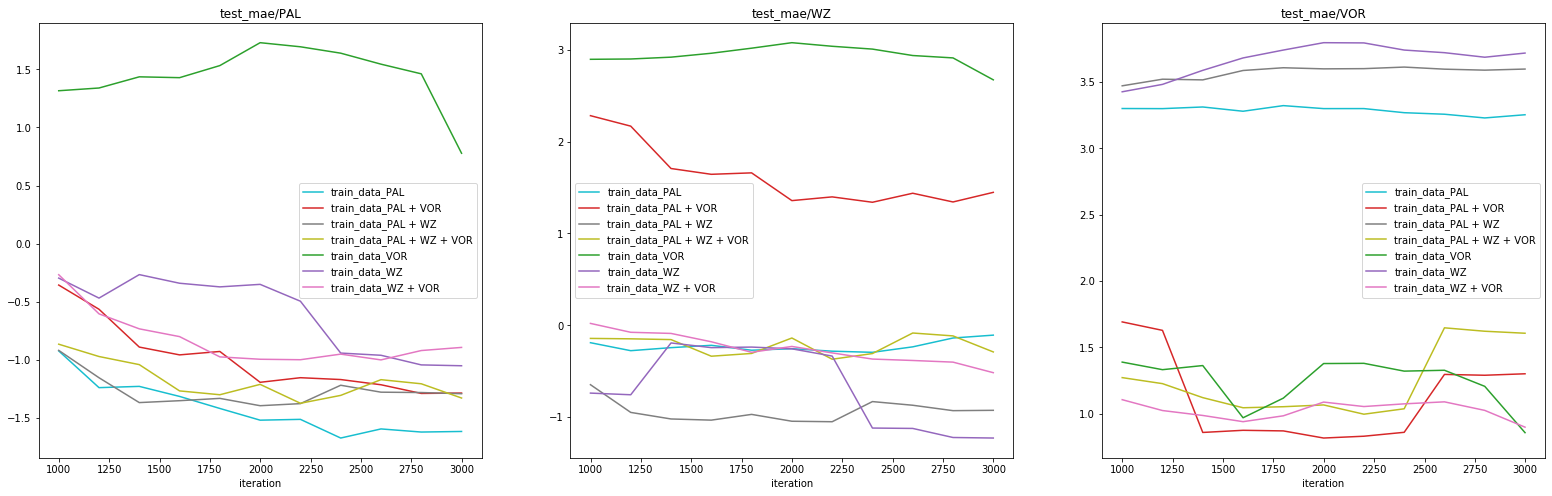

In [40]:
show_research(results.df, layout=['test_mae/PAL', 'test_mae/WZ', 'test_mae/VOR'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=True, rolling_window=5, scale=(9, 8))

In [36]:
print_results(results.df, 'test_mae/PAL', True, ascending=True, sort_by='test_mae_mean', n_last=10)

,test_mae_mean,test_mae_std
train_data_PAL,0.166774,NaN
train_data_PAL + WZ + VOR,0.181058,NaN
train_data_PAL + WZ,0.225984,NaN
train_data_PAL + VOR,0.272552,NaN
train_data_WZ + VOR,0.374330,NaN
train_data_WZ,0.400686,NaN
train_data_VOR,1.762874,NaN


In [37]:
print_results(results.df, 'test_mae/WZ', True, ascending=True, sort_by='test_mae_mean', n_last=10)

,test_mae_mean,test_mae_std
train_data_WZ,0.269674,NaN
train_data_PAL + WZ,0.340583,NaN
train_data_WZ + VOR,0.461562,NaN
train_data_PAL + WZ + VOR,0.476532,NaN
train_data_PAL,0.913919,NaN
train_data_PAL + VOR,5.063018,NaN
train_data_VOR,14.048554,NaN


In [38]:
print_results(results.df, 'test_mae/VOR', True, ascending=True, sort_by='test_mae_mean', n_last=10)

,test_mae_mean,test_mae_std
train_data_PAL + VOR,2.262511,NaN
train_data_WZ + VOR,2.356294,NaN
train_data_VOR,2.509419,NaN
train_data_PAL + WZ + VOR,2.801924,NaN
train_data_PAL,28.526073,NaN
train_data_PAL + WZ,34.217237,NaN
train_data_WZ,46.661088,NaN
